# Apples 2 Audiences

Data Challenge: August 3, 2020\
Candidate: Isaac Chung\
Time alloted: 4 hours\
Task: We want to reorganize the layout of our store to maximize sales. to do that, we would like to know if we can cluster types of groceries that are typically purchased together. What items do you recommend that we place together? Please return a clearly laid out notebook with explanations on your choices and clearly listed functions. You can use any clustering method you'd like.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

## 0. Import data
First let's import the data set, and see what's inside. Data is given in 3 csv files. Let's use pandas' read_csv function.

In [2]:
items = pd.read_csv('items.csv')
users = pd.read_csv('users.csv')
users_by_items = pd.read_csv('users_by_items.csv')

### 0.1 Items
There are a total of 48 items. They all have their own item IDs and prices. A quick check shows no duplicates.

In [3]:
items = items.set_index('Item_id')
print(items.head())
print(items.info())

          item_name  price
Item_id                   
1             sugar      2
2           lettuce      1
3         pet items      2
4        baby items      4
5           waffles      2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 1 to 48
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_name  48 non-null     object
 1   price      48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


In [4]:
items.duplicated().sum()

0

### 0.2 Users
There are a total of 39474 items. They all have their own user IDs and items bought. A quick check shows 14589 duplicates for the user_id column, which means there are repeating customers. This dataset shows the transactions. 

In [5]:
print(users.head())
print(users.info())

   user_id                                                 id
0   222087                                              27,26
1  1343649                                            6,47,17
2   404134                       18,12,23,22,27,43,38,20,35,1
3  1110200                                 9,23,2,20,26,47,37
4   224107  31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB
None


In [6]:
users.user_id.duplicated().sum()

14589

### 0.3 Users by items
There are a total of 24885 rows, which confirms our finding in the last csv file. Here the unique user_id is paired with the total purchases of each item. 

In [7]:
print(users_by_items.head())
print(users_by_items.info())

   user_id  1  2  3  4  5  6  7  8  9  ...  39  40  41  42  43  44  45  46  \
0   100002  0  0  0  0  0  0  0  0  0  ...   0   0   0   1   0   0   1   0   
1  1000074  0  1  0  0  0  0  1  1  0  ...   1   2   0   0   1   0   1   1   
2   100009  1  0  0  0  0  1  0  0  1  ...   2   0   1   0   0   0   1   0   
3  1000096  0  0  0  0  0  0  0  0  0  ...   1   0   1   0   1   0   0   0   
4  1000103  0  1  0  0  0  2  0  1  1  ...   2   1   0   1   1   2   1   1   

   47  48  
0   0   0  
1   0   1  
2   0   0  
3   0   0  
4   0   1  

[5 rows x 49 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24885 entries, 0 to 24884
Data columns (total 49 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  24885 non-null  int64
 1   1        24885 non-null  int64
 2   2        24885 non-null  int64
 3   3        24885 non-null  int64
 4   4        24885 non-null  int64
 5   5        24885 non-null  int64
 6   6        24885 non-null  int64
 7 

## 1. Exploratory Data Analysis
Let's first explore the data we have on hand. I begin by looking at the top 15 most bought items.

In [8]:
most_bought = users_by_items.sum(axis=0).nlargest(15)

In [9]:
most_bought

user_id    18685880131
2                14473
1                 9119
42                9050
25                9019
32                9008
44                8980
20                8951
46                8921
45                8902
40                8878
10                8859
9                 8816
38                8814
43                8784
dtype: int64

In [10]:
most_bought_items = list(most_bought.index)
most_bought_items.pop(0)
print(most_bought_items)

['2', '1', '42', '25', '32', '44', '20', '46', '45', '40', '10', '9', '38', '43']


To help read the item codes, we want a dictionary that converts item id to item names.

In [11]:
items_names = items.drop('price',axis=1).to_dict()

In [12]:
mb = []
for item in most_bought_items:
    mb.append(items_names['item_name'][int(item)])
print(mb)

['lettuce', 'sugar', 'cucumbers', 'cherries', 'apples', 'broccoli', 'grapefruit', 'bananas', 'cauliflower', 'berries', 'carrots', 'soda', 'juice', 'coffee']


## 2. Clustering
As a first step, I am going to try minibatch K-means clustering to save time compared to K-means. 

In [13]:
from sklearn.cluster import MiniBatchKMeans
from time import time

X = users_by_items.drop('user_id',axis=1)

In [14]:
t0 = time()
wcss = []
for i in range(1,20):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=i, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
    mbk.fit(X)
    wcss.append(mbk.inertia_)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)

Time taken to run MiniBatchKMeans 3.31 seconds


The goal of varying the `n_clusters` parameter is to find the optimal number of clusters by using the elbow method. Here we’ll consider the total intra-cluster variation (or total within-cluster sum of square (WSS)), and we’ll try to minimize it. 

The bend of the plot indicates the appropriate number of clusters. Here we can choose `n_clusters=5`.

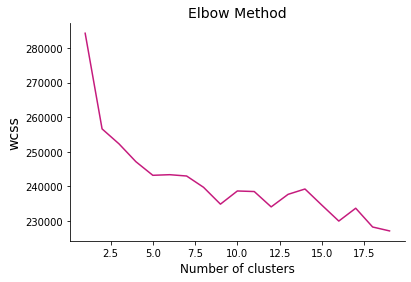

In [15]:
plt.plot(range(1,20), wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show() 

In [16]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=5, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
mbk.fit(users_by_items)

MiniBatchKMeans(n_clusters=5, n_init=10, random_state=0)

For clustering methods, the higher silhouette score the better. 

In [17]:
from sklearn.metrics import silhouette_score
print("Silhouette score of k-means clustering: {}".format(silhouette_score(X, mbk.labels_)))

Silhouette score of k-means clustering: -0.0018838646446956294


In [18]:
mbk.labels_.shape

(24885,)

In [19]:
mbk.fit(X.transpose())

MiniBatchKMeans(n_clusters=5, n_init=10, random_state=0)

In [20]:
mbk.labels_.shape

(48,)

In [21]:
print("Silhouette score of k-means clustering: {}".format(silhouette_score(X.transpose(), mbk.labels_)))

Silhouette score of k-means clustering: -0.026096560572054173


## 3. Topic Modelling
I was struggling with interpreting the model in the context of the data. Now I'm pivoting towards solving this clustering problem as a NLP topic modelling type problem. 

The given `users_by_items` matrix can be viewed as the output of corpus (purchases) being fed through the count vectorizer. Here we can use the following mapping for the terminology used in the two problems:\
1) Feature names: these are unique items -> unique shopping items\
2) Line/document -> each shopper/user

Here is a toy example from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
            'This is the first document.',
            'This document is the second document.',
            'And this is the third one.',
            'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

Here we see the similarity between the count matrix and the `users_by_items` matrix.

In [23]:
print(vectorizer.get_feature_names())
print(X.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In both problems, the items (words) order does not matter. We can use this fact to build a bag-of-words (BOW) model (here more so a bag-of-items), and use a topic modelling technique (such as LDA) to cluster the items. One can use sklearn's LDA module. 

Given more time, we can choose to use Gensim's in-built LDA model and use pyLDAvis to visualize these topics and their associates key words/n_grams.

In [24]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

import pyLDAvis
import pyLDAvis.gensim

from scipy import sparse

### LDA: 5 topics
We use Latent Dirichlet Allocation (LDA), an unsupervised generative model that assigns topic distributions to documents. Here we want it to assign item distributions to transactions. From the Elbow plot above, let's start with 5 topics/clusters.

In [25]:
from time import time
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, learning_method="online",
                                max_iter=10, random_state=0, n_jobs=3, 
                                verbose=0)

In [26]:
data = users_by_items.drop('user_id',axis=1)
sX = sparse.csr_matrix(data)

The following fit_transform function call takes a bit of time.

In [27]:
start = time()
topics = lda.fit_transform(sX)
print('LDA with 5 topics took %.1f seconds.' %(time()-start))

LDA with 5 topics took 94.4 seconds.


In [28]:
topics.shape

(24885, 5)

Here I'm sorting the components (i.e. the features/items) per topic in descending importance.

In [29]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

We see this variable gives lists of item ids. Let's convert them into item names.

In [30]:
sorting

array([[42, 37,  8, 22,  1, 14,  5, 16, 46, 43, 12,  9, 38, 44, 41, 33,
        36, 23,  0,  6, 32,  2, 30, 35, 21, 17, 29, 26,  3, 10, 28, 13,
        11, 27, 18, 40, 20, 45, 24, 31,  7, 39, 19, 47,  4, 25, 15, 34],
       [20, 47, 15,  7, 13, 12, 38, 36, 33,  1,  0, 44, 41,  9, 43,  2,
        21, 35, 26, 40, 27, 17, 25,  3, 30, 18,  4, 23,  8, 42, 22, 37,
        28, 32,  5,  6, 46, 11, 16, 39, 34, 31, 45, 24, 14, 19, 29, 10],
       [24, 39, 19, 31, 45, 36, 38, 33, 12,  8,  1, 42, 22, 37,  0,  2,
        21, 35, 26, 17, 30, 40, 29,  4, 32, 27,  9, 43, 41, 34, 44, 23,
        18,  6, 25, 28, 11, 13, 47, 14, 15,  7, 46,  5, 20,  3, 10, 16],
       [25, 27, 34, 11, 40, 42, 18, 46,  5, 28,  0, 22, 37, 16, 10,  8,
        26, 17,  4,  1,  2, 35, 21, 15, 29, 33, 13,  3, 12, 38, 36, 19,
        45, 39, 24, 23, 47, 44, 20,  7, 32, 31, 41,  6, 43,  9, 30, 14],
       [ 1, 41, 44,  9, 43, 16, 46,  5, 31, 45, 19, 24, 39, 25, 40,  2,
        27,  0,  7, 35, 17, 21, 26, 47,  3, 13, 20, 15, 22, 

We see some clear yet interesting trends here looking at the top 3 items from LDA with 5 topics. We've got drinks, dairy, fruits, mix of a few things, and vegetables. This tells us that we could increase the number of clusters. 

In [31]:
topic = []
topic_model = []
for topics in sorting:
    topic = []
    for item in topics:
        topic.append(items_names['item_name'][int(item)+1])
    topic_model.append(topic)
    print(topic[:3])


['coffee', 'juice', 'soda']
['cheeses', 'yogurt', 'milk']
['cherries', 'berries', 'grapefruit']
['spaghetti sauce', 'canned vegetables', 'soap']
['lettuce', 'cucumbers', 'cauliflower']


### LDA: 8 topics
Since spaghetti sauce, canned vegetables, and soap don't belong to the same group, we can deduce that 8 topics are not sufficient. Let's try LDA with 8 topics, and show the top 4 items.

In [32]:
lda8 = LatentDirichletAllocation(n_components=8, learning_method="online",
                                max_iter=10, random_state=0, n_jobs=3, 
                                verbose=0)

In [33]:
start = time()
topics8 = lda8.fit_transform(sX)
print('LDA with 8 topics took %.1f seconds.' %(time()-start))

LDA with 8 topics took 92.9 seconds.


Here we notice each of the 8 clusters 'make more sense'. We see coherent groupings like **meat**, **dairy**, **cleaning supplies**, **bread/loafs**, **beverages**, **fruits**, but still some inconsistencies exist. For example, we do not fully expect spaghetti sauce to be in the same grouping with pork and beef. One could expect to buy spaghetti sauce if spaghetti was also bought. Given more time, I would run the LDA model with one or more topics. A trivial upper bound of the number of topics is the number of distinct items (48), but then the topics would be meaningless. 

I can conclude here that these 8 topics are good enough to go with given the time limit. 

In [34]:
sorting8 = np.argsort(lda8.components_, axis=1)[:, ::-1]
topic = []
topic_model = []
for topics in sorting8:
    topic = []
    for item in topics:
        topic.append(items_names['item_name'][int(item)+1])
    topic_model.append(topic)
    print(topic[:4])

['poultry', 'beef', 'pork', 'spaghetti sauce']
['cheeses', 'milk', 'butter', 'yogurt']
['hand soap', 'aluminum foil', 'shaving cream', 'toilet paper']
['dinner rolls', 'sandwich loaves', 'tortillas', 'bagels']
['broccoli', 'cucumbers', 'carrots', 'cauliflower']
['soap', 'paper towels', 'flour', 'shampoo']
['juice', 'coffee', 'soda', 'tea']
['grapefruit', 'berries', 'cherries', 'apples']


## Takeaway
1) To answer the original question, we can place the items that are in the same topic group together as shown in the above cell. Even though we are not using some of the common cluster methods like K-means and DBSCAN, we can apply topic modelling techniques to solve a highly similar problem.\
2) What could enrich this notebook is a metric that validates the LDA models. Right now we are assessing the effectiveness of the LDA models with 'common sense', e.g. 'spaghetti sauce' does not belong with cleaning supplies. One metric that comes to mind that would address the root purpose of this exercise is sales. We were asked to "maximize sales", and a natural next step is to account for the price of these topic groupings. Perhaps I can start exploring the average cost per transaction, then measure the average price for each topic.